For mrm rings:
Avg. lifetime for 1 defect per 488281 Jaguars: 192 years
Min. operational lifetime for 1 defect per 488281 Jaguars: 2.0 years
Max. operational lifetime for 1 defect per 488281 Jaguars: 85155348 years


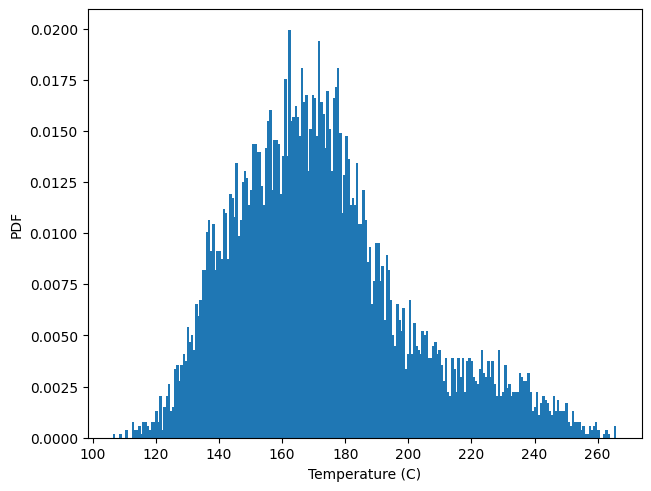

For crr rings:
Avg. lifetime for 1 defect per 488281 Jaguars: 48 years
Min. operational lifetime for 1 defect per 488281 Jaguars: 1.5 years
Max. operational lifetime for 1 defect per 488281 Jaguars: 116875653 years


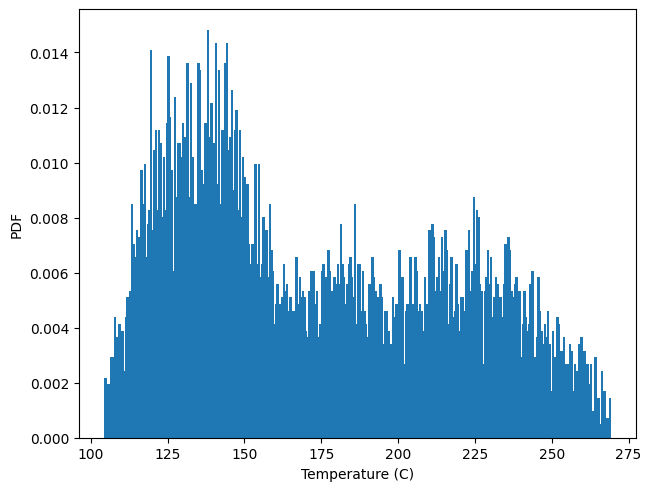

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

"""
CONSTANTS
"""
k = 8.617333262145e-5 # Boltzmann constant in eV/K

# These two parameters are based on the measurements in "Nickel Silicide
# Electromigration on Micro Ring Modulators for Silicon Photonics Technology"
# paper by GlobalFoundries
Ea = 1.95 # eV
A = 1.2e-18  # in years

# These constants are based on the search and lock simulations
STEP_SIZE = 5  # in GHz
MRM_FSR = 1800  # in GHz
CRR_FSR = 1800  # in GHz
NUM_OF_LASERS = 8
COOLDOWN = 400  # in GHz

# These dT to FSR conversion is based on FS measurements
MRM_dT_FSR = 156 # degC
CRR_dT_FSR = 162.4 # degC

MIN_CHIP_TEMP = 10 # degC
MAX_CHIP_TEMP = 105 # degC

MRM_MAIN_HTR_RTH = 10972 # degC/W
CRR_HTR_RTH = 10068 # degC/W

MRM_MAIN_HTR_PFSR = 22e-3 # W/FSR
CRR_HTR_PFSR = 18.4e-3 # W/FSR



def convert_freq_to_temperature(freq, type='mrm'):
    if type == 'mrm':
        freq2temp = MRM_MAIN_HTR_PFSR * MRM_MAIN_HTR_RTH / MRM_FSR  # K/GHz
    elif type == 'crr':
        freq2temp = CRR_HTR_PFSR * CRR_HTR_RTH / CRR_FSR  # K/GHz

    temp_step_size = STEP_SIZE * freq2temp

    # MAX_CHIP_TEMP occurs at +COOLDOWN GHz
    # For example, 105 degC occurs at +400 GHz cooling, 
    # and remember that heating is negative
    temp = (freq - COOLDOWN) * freq2temp
    temp = MAX_CHIP_TEMP + np.abs(temp) # in C

    # temp = np.clip(temp, 200, None)  # clip anything below 200 C to prevent extrapolating
    temp += 273.15  # convert to K

    return temp, temp_step_size  # in K


def get_temperatures(trial_results, type='mrm'):
    frequencies = np.array(trial_results[range(NUM_OF_LASERS)]).reshape(-1)
    temperatures, temp_step_size = convert_freq_to_temperature(frequencies, type)
    return temperatures, temp_step_size

def get_histogram(trial_results, type='mrm'):
    temperatures, temp_step_size = get_temperatures(trial_results, type)
    temp_bins = np.arange(temperatures.min() - temp_step_size/2, temperatures.max() + temp_step_size/2, temp_step_size)
    # hist, bins = np.histogram(temp_counts, bins=temp_bins, density=False)
    # hist = hist.astype(float) / len(counts)
    hist, bins = np.histogram(temperatures, bins=temp_bins, density=True)
    return hist, bins


def MTTF(T):  # Mean time to failure
    return A * np.exp(Ea / (k*T))


def failure_rate(T):
    return 1/MTTF(T)


def get_averaged_lifetime(hist, temp_bins):
    """
    hist: 1D np.ndarray, histogram of temperatures related to temp_bins below
    temp_bins: 1D np.ndarray, temperatures in K
    operational_time: 1D np.ndarray, in number of operational years"""

    # the actual temperature is at the middle of the bins
    T = .5 * (temp_bins[:-1] + temp_bins[1:])
    dT = temp_bins[1] - temp_bins[0]
    # FIXME: should we average lifetime or should we average failure_rate
    # failure rate per year, shape [temp,]
    lam = failure_rate(T)
    averaged_lam = np.sum(lam * hist, axis=-1) * dT
    averaged_lifetime = 1/averaged_lam
    return averaged_lifetime


HEATER_SEGMENTS_PER_RING = 4
RINGS_PER_BANK = 8
BANKS_PER_JAGUAR = 64
JAGUAR_PER_MRB = 1
MRB_PER_SUPERNODE = 4
SUPERNODE_PER_TANK = 32
TANK_PER_DC = 256

# Number of heaters in the entire DC for a specific type
# N_heaters = HEATER_SEGMENTS_PER_RING * RINGS_PER_BANK * BANKS_PER_JAGUAR * \
#     JAGUAR_PER_MRB * MRB_PER_SUPERNODE * SUPERNODE_PER_TANK * TANK_PER_DC
# Number of heaters in a Jaguar for a specific type
N_heaters = HEATER_SEGMENTS_PER_RING * RINGS_PER_BANK * BANKS_PER_JAGUAR

"""
Compute lifetime
"""
trial_results_mrm = pd.read_pickle('trial_results_mrm.pkl')
trial_results_crr = pd.read_pickle('trial_results_crr.pkl')

def analyze_data(trial_results, type):
    temperatures, _ = get_temperatures(trial_results, type)
    hist, temp_bins = get_histogram(trial_results, type)
    avg_lifetime = get_averaged_lifetime(hist, temp_bins)
    min_lifetime = MTTF(temperatures.max())
    max_lifetime = MTTF(temperatures.min())

    # FIXME: This interpreation seems correct, Ashwyn please confirm?
    print(f"For {type} rings:")
    print(f"Avg. lifetime for 1 defect per {int(1e9/N_heaters)} Jaguars: {avg_lifetime:.0f} years")
    print(f"Min. operational lifetime for 1 defect per {int(1e9/N_heaters)} Jaguars: {min_lifetime:.1f} years")
    print(f"Max. operational lifetime for 1 defect per {int(1e9/N_heaters)} Jaguars: {max_lifetime:.0f} years")

    import matplotlib.pyplot as plt
    # Plot the temperatures
    fig, ax = plt.subplots(constrained_layout=True)
    ax.bar(temp_bins[:-1] - 273.15, hist)
    ax.set_xlabel('Temperature (C)')
    ax.set_ylabel('PDF')
    plt.show()

# analyze the MRMs
analyze_data(trial_results_mrm, 'mrm')
# analyze the CRRs
analyze_data(trial_results_crr, 'crr')

def get_averaged_reliability(hist, temp_bins, operational_time):
    """
    hist: 1D np.ndarray, histogram of temperatures related to temp_bins below
    temp_bins: 1D np.ndarray, temperatures in K
    operational_time: 1D np.ndarray, in number of operational years
    """

    # the actual temperature is at the middle of the bins
    T = .5 * (temp_bins[:-1] + temp_bins[1:])
    dT = temp_bins[1] - temp_bins[0]
    lam = failure_rate(T)
    # failure rate per year, shape [temp, 1]
    lam = np.expand_dims(lam, -1)
    # reliability function, shape [time, temp]
    R = np.exp(-lam * operational_time).T
    # averaged reliability, shape [time]
    averaged_R = np.sum(R * hist, axis=-1) * dT
    return averaged_R

## Analysis from the GF reliability paper

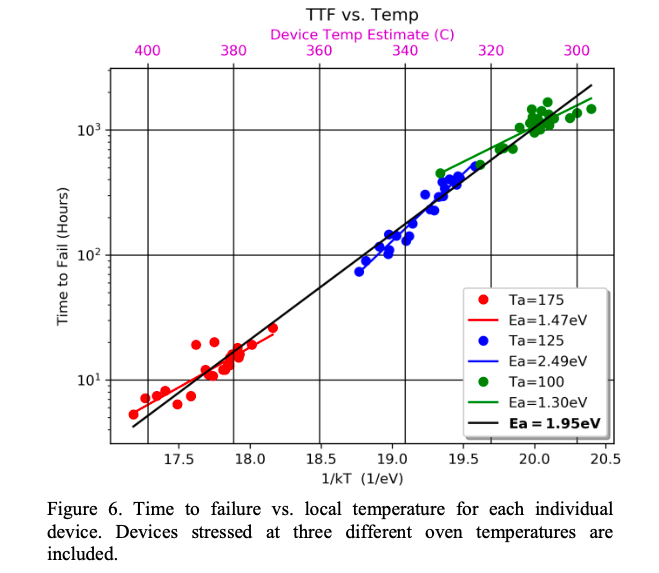

To do a fit with Fig. 6:
X intercept at 17.5 + (17/68 * .5) = 17.5 + (.25 * .5) = 17.625 \
Y intercept at 10^1 = 10 hours \
To calculate `A`, we just compute `A  = np.exp(np.log(10) - (Ea * 17.625))`
giving us `A ~ 1.2e-14` in hours.\
However, I believe that this value of $A$ isn't the right one because it's from accelerated testing.

This equation gives us:
$MTTF = A \exp(Ea / kT)$

FIT rate is the number of failures expected in 1B device-hours of operation.
`MTTF = 1e9 x 1/FIT`

Also,
$MTTF = 1/\lambda$ where $\lambda$ is the failure rate per time (hour or year).

Thus we have:
$\lambda = 1/A \times exp(-Ea/kT)$ in units of per hour/year.

The reliability function is
$R(t) = exp(-\lambda t)$ which gives us the reliability function or the probability that a device will survive after some operational time `t`.

$\lambda(T)$ however is a function of temperature and there's a distribution of temperatures due to different heating set points.\
To find the averaged $R(t)$, we need to average $R(t,T) = \exp(-\lambda(T) t)$ using the PDF evaluated from the Monte Carlo.\
This PDF $f(T)$ can just be calculated by defining a specific bin size (e.g., 5 GHz) and then normalizing by the `sum(counts)`.
In other words, $R(t) = \int R(t,T) f(T) dT$, and this gives us\
$R(t) = \exp(- \lambda' t)$ where $\lambda'$ is the averaged value of $\lambda$.

From here, we can just plot $R(t)$ against $t$ or against $t'$, where $t' = t/N$ is the actual time.